In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, compute_tilt_data, bearing, ellipse_aspect_ratio, phys_grad, compute_core_mean

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')
df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_AE = df_eddies[df_eddies.Cyc=='AE'].copy().dropna()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy().dropna()
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,...,q22,Rc,psi0,A,R,Age,Date,fname,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,...,0.943344,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,...,0.950849,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,...,1.006892,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,...,1.200119,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,...,1.214160,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,...,1.156400,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,...,1.238286,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,13.627106,324.784689
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,...,1.163994,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,...,1.203104,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]


/home/z5297792/myenv310/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/z5297792/myenv310/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1619: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


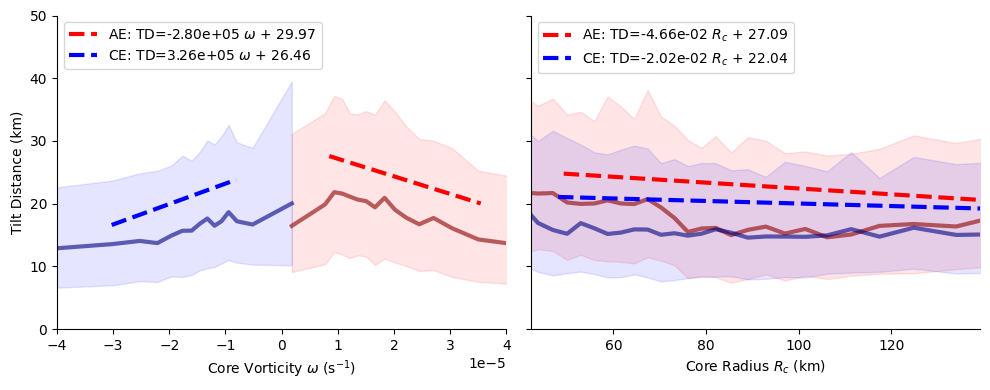

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

styles = {
    'AE': {'line': 'darkred', 'fill': 'red'},
    'CE': {'line': 'navy',    'fill': 'blue'}
}

# ============================================================
# PANEL 1 — TiltDis vs core vorticity ω
# ============================================================
ax = axs[0]

df_all = df_eddies.dropna(subset=['w'])
N_all = df_all.w.values

bins = np.unique(np.quantile(N_all, np.linspace(0, 1, 31)))
bin_centers = 0.5 * (bins[:-1] + bins[1:])

lo, hi = np.inf, -np.inf
for cyc in ['AE', 'CE']:

    df = df_eddies[(df_eddies.Cyc == cyc)].dropna(subset=['w', 'TiltDis'])
    xval, tilt = df.w.values, df.TiltDis.values

    d = np.digitize(xval, bins)

    med = [np.nanmedian(tilt[d == i]) for i in range(1, len(bins))]
    q25 = [np.nanquantile(tilt[d == i], .25) for i in range(1, len(bins))]
    q75 = [np.nanquantile(tilt[d == i], .75) for i in range(1, len(bins))]

    ax.plot(bin_centers, med, lw=3, color=styles[cyc]['line'], alpha=.6)
    ax.fill_between(bin_centers, q25, q75, color=styles[cyc]['fill'], alpha=.10)

    Nmin, Nmax = np.nanpercentile(xval, [10, 90])
    lo, hi = min(lo, Nmin), max(hi, Nmax)

    m, c, *_ = linregress(xval[(xval >= Nmin) & (xval <= Nmax)],
                          tilt[(xval >= Nmin) & (xval <= Nmax)])

    xfit = np.linspace(Nmin, Nmax, 200)
    ax.plot(xfit, m*xfit + c, '--', lw=3, color=styles[cyc]['fill'],
            label=fr'{cyc}: TD={m:.2e} $\omega$ {"-" if c<0 else "+"} {abs(c):.2f}')

ax.set_xlim(-4e-5, 4e-5)
ax.set_xlabel(r'Core Vorticity $\omega$ (s$^{-1}$)')
ax.set_ylabel('Tilt Distance (km)')
ax.legend(ncol=1, loc='upper left')

# ============================================================
# PANEL 2 — TiltDis vs Rc
# ============================================================
ax = axs[1]

df_all = df_eddies.dropna(subset=['Rc'])
N_all = df_all.Rc.values

bins = np.unique(np.quantile(N_all, np.linspace(0, 1, 31)))
bin_centers = 0.5 * (bins[:-1] + bins[1:])

for cyc in ['AE', 'CE']:

    df = df_eddies[(df_eddies.Cyc == cyc)].dropna(subset=['Rc', 'TiltDis'])
    xval, tilt = df.Rc.values, df.TiltDis.values

    d = np.digitize(xval, bins)

    med = [np.nanmedian(tilt[d == i]) for i in range(1, len(bins))]
    q25 = [np.nanquantile(tilt[d == i], .25) for i in range(1, len(bins))]
    q75 = [np.nanquantile(tilt[d == i], .75) for i in range(1, len(bins))]

    ax.plot(bin_centers, med, lw=3, color=styles[cyc]['line'], alpha=.6)
    ax.fill_between(bin_centers, q25, q75, color=styles[cyc]['fill'], alpha=.10)

    Nmin, Nmax = np.nanpercentile(xval, [10, 90])
    m, c, *_ = linregress(xval[(xval >= Nmin) & (xval <= Nmax)],
                          tilt[(xval >= Nmin) & (xval <= Nmax)])

    xfit = np.linspace(Nmin, Nmax, 200)
    ax.plot(xfit, m*xfit + c, '--', lw=3, color=styles[cyc]['fill'],
            label=fr'{cyc}: TD={m:.2e} $R_c$ {"-" if c<0 else "+"} {abs(c):.2f}')

ax.set_xlim(*np.nanpercentile(N_all, [10, 90]))
ax.set_xlabel(r'Core Radius $R_c$ (km)')
ax.legend(ncol=1, loc='upper left')

# ============================================================
# Final formatting
# ============================================================
for ax in axs:
    ax.set_ylim(0, 50)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()



In [40]:
# Aspect Ratio
ARs = []
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    ARs.append(ellipse_aspect_ratio(data.q11, data.q12, data.q22))
df_eddies['AR'] = ARs


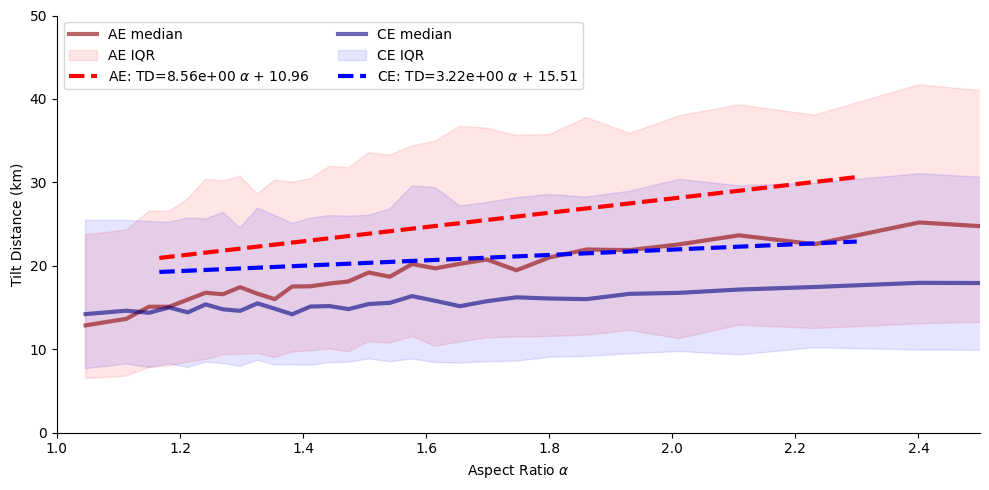

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['AR'])
N_all = df_all.AR.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['AR', 'TiltDis'])

    xval = df_masked['AR'].values
    tilt = df_masked['TiltDis'].values

    # bin everything — no masking whatsoever
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
    #        color=styles[cyc]['fill'])    

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')

    # ------------------------------------------------------------
    # Linear regression on a chosen interval of xval
    # (keep this if you want restricted-slope fitting)
    # ------------------------------------------------------------
    Nmin, Nmax = np.nanpercentile(N_all, [10, 90])
    # Nmin, Nmax = bin_centers.min(), bin_centers.max()
    mask_reg = (xval >= Nmin) & (xval <= Nmax)

    if mask_reg.sum() > 2:
        xr = xval[mask_reg]
        yr = tilt[mask_reg]

        m, c, r, p, se = linregress(xr, yr)

        x_fit = np.linspace(Nmin, Nmax, 200)
        y_fit = m * x_fit + c

        ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
                label=fr'{cyc}: TD={m:.2e} $\alpha$ {"-" if c<0 else "+"} {abs(c):.2f}')

# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 50)
ax.set_xlim(1, 2.5)
ax.set_xlabel(r'Aspect Ratio $\alpha$')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left', ncol=2)

plt.tight_layout()
plt.show()




/home/z5297792/myenv310/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/z5297792/myenv310/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1619: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


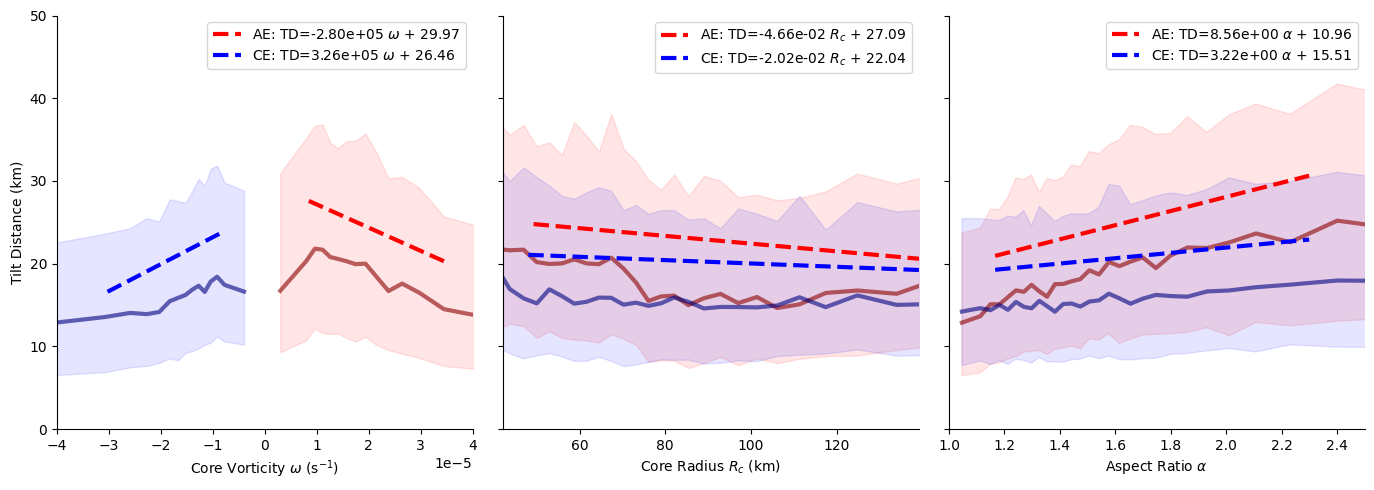

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

styles = {
    'AE': {'line': 'darkred', 'fill': 'red'},
    'CE': {'line': 'navy',    'fill': 'blue'}
}

# ============================================================
# PANEL 1 — Core vorticity ω
# ============================================================
ax = axs[0]

df_all = df_eddies.dropna(subset=['w'])
w = df_all.w.values
# split by sign
w_neg, w_pos = w[w < 0], w[w > 0]
nbins = 15   # 15 neg + 15 pos = 30 total (match your old 31 edges)
# quantile bins separately
bins_neg = np.quantile(w_neg, np.linspace(0, 1, nbins + 1))
bins_pos = np.quantile(w_pos, np.linspace(0, 1, nbins + 1))
# enforce monotonicity & avoid overlap at zero
bins_neg, bins_pos = np.unique(bins_neg), np.unique(bins_pos)
# combine (negative first, then positive)
bins = np.concatenate([bins_neg, bins_pos[1:]])
bin_centers = 0.5 * (bins[:-1] + bins[1:])

for cyc in ['AE', 'CE']:
    df = df_eddies[df_eddies.Cyc == cyc].dropna(subset=['w', 'TiltDis'])
    xval, tilt = df.w.values, df.TiltDis.values

    d = np.digitize(xval, bins)
    med = [np.nanmedian(tilt[d == i]) for i in range(1, len(bins))]
    q25 = [np.nanquantile(tilt[d == i], .25) for i in range(1, len(bins))]
    q75 = [np.nanquantile(tilt[d == i], .75) for i in range(1, len(bins))]

    ax.plot(bin_centers, med, lw=3, color=styles[cyc]['line'], alpha=.6)
    ax.fill_between(bin_centers, q25, q75, color=styles[cyc]['fill'], alpha=.10)

    Nmin, Nmax = np.nanpercentile(xval, [10, 90])
    m, c, *_ = linregress(xval[(xval >= Nmin) & (xval <= Nmax)],
                          tilt[(xval >= Nmin) & (xval <= Nmax)])
    xf = np.linspace(Nmin, Nmax, 200)
    ax.plot(xf, m*xf + c, '--', lw=3, color=styles[cyc]['fill'],
            label=fr'{cyc}: TD={m:.2e} $\omega$ {"-" if c<0 else "+"} {abs(c):.2f}')

ax.set_xlim(-4e-5, 4e-5)
ax.set_xlabel(r'Core Vorticity $\omega$ (s$^{-1}$)')
ax.set_ylabel('Tilt Distance (km)')
ax.legend(ncol=1)

# ============================================================
# PANEL 2 — Core radius Rc
# ============================================================
ax = axs[1]

df_all = df_eddies.dropna(subset=['Rc'])
N_all = df_all.Rc.values

bins = np.unique(np.quantile(N_all, np.linspace(0, 1, 31)))
bin_centers = 0.5 * (bins[:-1] + bins[1:])

for cyc in ['AE', 'CE']:
    df = df_eddies[df_eddies.Cyc == cyc].dropna(subset=['Rc', 'TiltDis'])
    xval, tilt = df.Rc.values, df.TiltDis.values

    d = np.digitize(xval, bins)
    med = [np.nanmedian(tilt[d == i]) for i in range(1, len(bins))]
    q25 = [np.nanquantile(tilt[d == i], .25) for i in range(1, len(bins))]
    q75 = [np.nanquantile(tilt[d == i], .75) for i in range(1, len(bins))]

    ax.plot(bin_centers, med, lw=3, color=styles[cyc]['line'], alpha=.6)
    ax.fill_between(bin_centers, q25, q75, color=styles[cyc]['fill'], alpha=.10)

    Nmin, Nmax = np.nanpercentile(xval, [10, 90])
    m, c, *_ = linregress(xval[(xval >= Nmin) & (xval <= Nmax)],
                          tilt[(xval >= Nmin) & (xval <= Nmax)])
    xf = np.linspace(Nmin, Nmax, 200)
    ax.plot(xf, m*xf + c, '--', lw=3, color=styles[cyc]['fill'],
            label=fr'{cyc}: TD={m:.2e} $R_c$ {"-" if c<0 else "+"} {abs(c):.2f}')

ax.set_xlim(*np.nanpercentile(N_all, [10, 90]))
ax.set_xlabel(r'Core Radius $R_c$ (km)')
ax.legend(ncol=1)

# ============================================================
# PANEL 3 — Aspect ratio α
# ============================================================
ax = axs[2]

df_all = df_eddies.dropna(subset=['AR'])
N_all = df_all.AR.values

bins = np.unique(np.quantile(N_all, np.linspace(0, 1, 31)))
bin_centers = 0.5 * (bins[:-1] + bins[1:])

for cyc in ['AE', 'CE']:
    df = df_eddies[df_eddies.Cyc == cyc].dropna(subset=['AR', 'TiltDis'])
    xval, tilt = df.AR.values, df.TiltDis.values

    d = np.digitize(xval, bins)
    med = [np.nanmedian(tilt[d == i]) for i in range(1, len(bins))]
    q25 = [np.nanquantile(tilt[d == i], .25) for i in range(1, len(bins))]
    q75 = [np.nanquantile(tilt[d == i], .75) for i in range(1, len(bins))]

    ax.plot(bin_centers, med, lw=3, color=styles[cyc]['line'], alpha=.6)
    ax.fill_between(bin_centers, q25, q75, color=styles[cyc]['fill'], alpha=.10)

    Nmin, Nmax = np.nanpercentile(N_all, [10, 90])
    m, c, *_ = linregress(xval[(xval >= Nmin) & (xval <= Nmax)],
                          tilt[(xval >= Nmin) & (xval <= Nmax)])
    xf = np.linspace(Nmin, Nmax, 200)
    ax.plot(xf, m*xf + c, '--', lw=3, color=styles[cyc]['fill'],
            label=fr'{cyc}: TD={m:.2e} $\alpha$ {"-" if c<0 else "+"} {abs(c):.2f}')

ax.set_xlim(1, 2.5)
ax.set_xlabel(r'Aspect Ratio $\alpha$')
ax.legend(ncol=1)

# ============================================================
# Final formatting
# ============================================================
for ax in axs:
    ax.set_ylim(0, 50)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


